# Train models based on balanced dataset
## Read the dataset
The here used dataset is a version with selected features based on the EDA and feature selection. See EDA_Feature_Selection notebook for the reasoning of choices made.

In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('parkinson_feature_selection.csv')
df = df.iloc[: , 1:]
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(Abs),HNR,RPDE,D2,DFA,spread2,status
0,119.992,157.302,74.997,0.00007,21.033,0.414783,2.301442,0.815285,0.266482,1
1,122.400,148.650,113.819,0.00008,19.085,0.458359,2.486855,0.819521,0.335590,1
2,116.682,131.111,111.555,0.00009,20.651,0.429895,2.342259,0.825288,0.311173,1
3,116.676,137.871,111.366,0.00009,20.644,0.434969,2.405554,0.819235,0.334147,1
4,116.014,141.781,110.655,0.00011,19.649,0.417356,2.332180,0.823484,0.234513,1


## Prepare the data

In [3]:
# store target variable y
y = df.status.values

# create feature matrix
X = np.array(df.loc[ : , df.columns != 'status']) # these are the features (matrix)
X.shape

(195, 9)

In [4]:
# Normalize the data
def normalize(X):
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    return X

X = normalize(X)

## Conduct group balancing

There are two options to balance the groups:
- undersampling: reduce samples in the majority class 
- oversampling: increase number of samples in the minority class 
Undersampling may discard a lot of information while oversampling might be a costly task to conduct. Undersampling could be conducted using TOMEK technique, which picks quite close data points from opposite classes (pairs) and discards the points from each pair which belongs to the majority class. Here this would lead to loss of a lot of data so oversampling is prefered. Here conducted is the SMOTE technique, which measures the distances between the minority class and creates synthetic observations inbetween adjacent observations from the minority class [https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/].

In [5]:
def make_barplot(y):
    ar_unique, counts = np.unique(y, return_counts = True)
    plt.bar(ar_unique, counts)
    plt.show()
    print(counts)

Original dataset shape (195,)


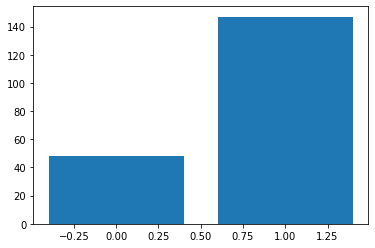

[ 48 147]
Resample dataset shape (294,)


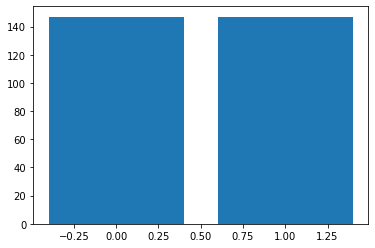

[147 147]


In [6]:
# build smote model
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

# print the original data shape
print('Original dataset shape', y.shape)
make_barplot(y)

# print resampled data shape
print('Resample dataset shape', y_smote.shape)
make_barplot(y_smote)

# Built, train and evaluate models
Several classifiers are build: 
- logistic regression
- naive Bayes
- XGBoost 

The models are split into 80% training data and 20% test/validation dataset. 

The evaluation metrics used here are accuracy (to get an impression of the overall accuracy, it is a suitable measure here because groups were balanced prior to modelling). Further the confusion matrix is computed. From the confusion matrix especially the False negative predictions are important to check, because it would result in a lot of other diagnostics conducted to find the reason for the dysphonia apart from Parkinson. False positives are more acceptable, because a following MRI scan could verify the diagnosis. Since a lof False negative rate is desired recall measure is an important measure too.  

In medical diagnostics a gold standard for accuracy is 95%, which is desired to achieve here as well. Moreover, the number of false negative predictions should be very small. Further, recall should be above 80%. 

In [7]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = .2, random_state = 1)

In [20]:
# predefine some functions to evaluate the models

# evaluation metrics
def evaluate(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# learning curve
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(30, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="validation data")
    plt.legend(loc="upper right", fontsize=10)   
    plt.xlabel("Training set size", fontsize=10) 
    plt.ylabel("RMSE", fontsize=10)     
    # compare accuracy train versus test to access overfit 
    print(f'test  acc: {model.score(X_val, y_val)}')
    print(f'train acc: {model.score(X_train, y_train)}')

### Logistic regression:

[[20  9]
 [ 6 24]]
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        29
           1       0.73      0.80      0.76        30

    accuracy                           0.75        59
   macro avg       0.75      0.74      0.74        59
weighted avg       0.75      0.75      0.74        59

-0.4458  MDVP:Fo(Hz)
-0.3673  MDVP:Fhi(Hz)
-0.1788  MDVP:Flo(Hz)
0.1206  MDVP:Jitter(Abs)
-0.3712  HNR
0.1755  RPDE
1.144  D2
0.3536  DFA
0.5882  spread2
test  acc: 0.711864406779661
train acc: 0.7574468085106383


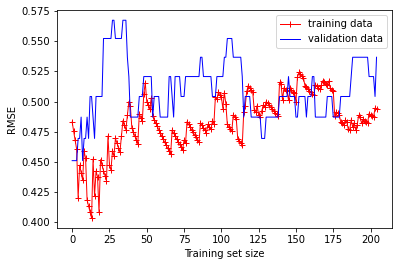

In [33]:
# logistic regression
# train the model
logreg = LogisticRegression(random_state = 1)
logreg_model = logreg.fit(X_train, y_train)

# make prediction
y_pred = logreg.predict(X_test)

# evaluate models predcitions
evaluate(y_test, y_pred)

# print the weights
for i in logreg.coef_:
       for index, j in enumerate(i):        
            print(f"{j:.4}  {list(df.columns.values)[index]}")

# plot learning curve
plot_learning_curves(logreg_model, X_train, y_train, X_test, y_test)

The logistic regression model was here used as an baseline classifier. It has an accuracy aroond 74%, which is far below the desired 95%. Recall is pretty low for the class as well. There are also quite a lot (12) false negative predictions. Learning curve does show that the performance is not improving with providing more trainings data. 

[[21  8]
 [ 7 23]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        29
           1       0.74      0.77      0.75        30

    accuracy                           0.75        59
   macro avg       0.75      0.75      0.75        59
weighted avg       0.75      0.75      0.75        59

test  acc: 0.7457627118644068
train acc: 0.7531914893617021


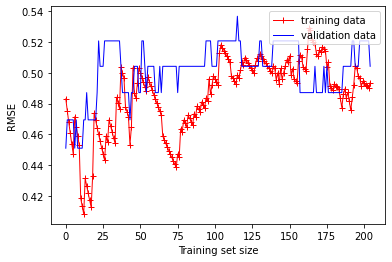

In [22]:
# improve model with AdaBoost
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(LogisticRegression(), n_estimators = 10, learning_rate = 1)
adb.fit(X_train, y_train)

y_pred = adb.predict(X_test)

evaluate(y_test, y_pred)

plot_learning_curves(adb, X_train, y_train, X_test, y_test)

The boosting did not improve the models performance. The logistic regression model was still picked for ensemble methods later on.

### Naive Bayes
Naive Bayes was considered to be an good model choice, because it is an simple model approach and assumes independent features. Here only features are used, which do not correlate. From the naive Bayes classifiers, gaussian naive bayes was selected, because the features were scaled to be bell shaped using standard scaler.

[[23  6]
 [10 20]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        29
           1       0.77      0.67      0.71        30

    accuracy                           0.73        59
   macro avg       0.73      0.73      0.73        59
weighted avg       0.73      0.73      0.73        59

test  acc: 0.7288135593220338
train acc: 0.7489361702127659


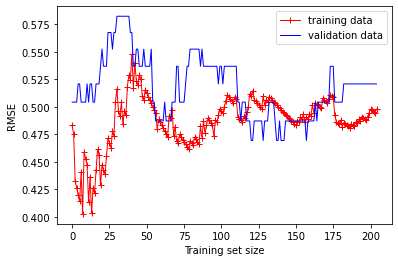

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

evaluate(y_test, y_pred)

plot_learning_curves(gnb, X_train, y_train, X_test, y_test)

The false negative prediction ratio increased in comparison to the logistic regression model. Similarly precision recall and f1 socres where lower. Overall accuracy was quite low as well. The learning curve shape looked okay, however the error was too high. Therefore, Grid search was applied to finetune the hyperparameters for the naive Bayes [https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba], however, the improvements were very small. 

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0,-10, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

y_pred = nbModel_grid.predict(X_test)

evaluate(y_test, y_pred)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.4977023564332111)
[[22  7]
 [ 9 21]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        29
           1       0.75      0.70      0.72        30

    accuracy                           0.73        59
   macro avg       0.73      0.73      0.73        59
weighted avg       0.73      0.73      0.73        59



The metrics improved only slightly, which makes Naive Bayes not a good model choice in the end.

### Random Forest Classifier

[[29  0]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        30

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

test  acc: 1.0
train acc: 1.0


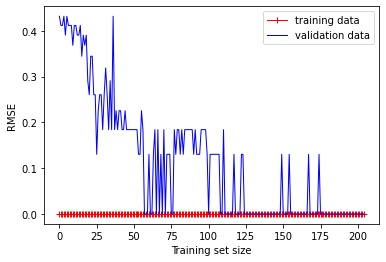

In [27]:
# load library
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance

evaluate(y_test, rfc_predict)

plot_learning_curves(rfc, X_train, y_train, X_test, y_test)

The random forest classifier was massively overfitting the data.

### Support vector machine

[[28  1]
 [ 1 29]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.97      0.97      0.97        30

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

test  acc: 0.9661016949152542
train acc: 0.9361702127659575


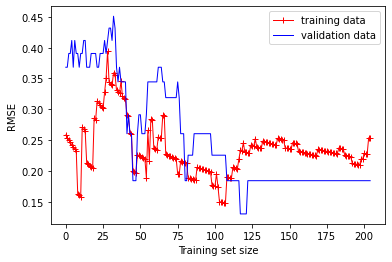

In [29]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
evaluate(y_test, y_pred)

plot_learning_curves(svm, X_train, y_train, X_test, y_test)

Best model so far, no overfitting, good performance on the training and validation data.

### Extreme gradient boost classifier
Was promising model, since it uses boosting to learn from where the decision trees go wrong. However hyperparameter tuning is crucial.

[23:03:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:03:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:03:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:03:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:03:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[23:03:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:03:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

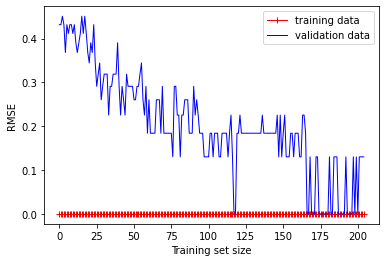

In [42]:
#xgboost classifier
xgb_model = XGBClassifier(objective='binary:logistic').fit(X_train, y_train)

# predict
xgb_y_predict = xgb_model.predict(X_test)

plot_learning_curves(xgb_model, X_train, y_train, X_test, y_test)

evaluate(y_test, xgb_y_predict)

The model was overfitted, hyperparameter tuning is necessary to circumvent it.

### Ensemble method Stacking

[[28  1]
 [ 1 29]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.97      0.97      0.97        30

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

test  acc: 0.9661016949152542
train acc: 0.9319148936170213


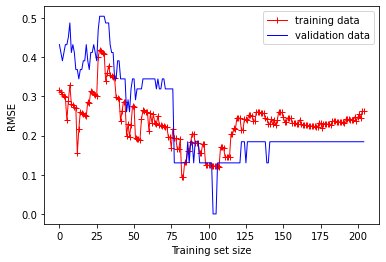

In [41]:
from sklearn.ensemble import StackingClassifier
estimators = [('logreg',logreg), ('svm', svm), ('gnb', gnb)]
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_train, y_train)

y_pred = sclf.predict(X_test)
evaluate(y_test, y_pred)
plot_learning_curves(sclf, X_train, y_train, X_test, y_test)